# Image classification

In this notebook, I train a neural network capable of recognising the type of a place shown in the picture. <br>More formally, the problem is to accurately classify 15k images from the <a href="http://web.mit.edu/torralba/www/indoor.html">Interior Scene Recognition dataset</a> into 67 classes, each corresponding to a different space (bedroom, airport inside, bar etc.)<br><br><b>Spoiler:</b> the network attained 85-86% accuracy on the test dataset

### Imports and setups

In [1]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import torchvision.models as models
import torch
import cv2
import albumentations.pytorch

from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from torch.nn import Softmax
from tqdm.auto import tqdm
from glob import glob

softmax = Softmax(dim=0)
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

/home/akruglov/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preparing the data

The dataframe with img filenames and their corresponding classes was created.<br><br><b>Note:</b> when set to 'True', the 'disbalanced' argument adds distortions to the dataset by making the smaller classes shrink more. It was used in the experiments on maximizing the F1-measure, but without much result.

In [2]:
label_dict = {label:i for i, label in enumerate(sorted(os.listdir('Images/')))}
names, labels = [], []
for label_name, label in label_dict.items():
    files = glob(f'Images/{label_name}/*.jpg')
    names.extend(files)
    labels.extend([label for _ in range(len(files))])
df = pd.DataFrame({'file':names, 'label':labels})
df['file'] = df['file'].apply(lambda x: x.replace('\\', '/'))
df['tmp'] = df['label'].astype(str) + df['file'].apply(lambda x: ': ' + x.split('/')[1])
df_new = df.groupby(['tmp']).count().sort_values(by='label')
fig = px.histogram(df_new, x=df_new.index, y=df_new['label'], title="Original Dataset")
fig.update_layout(yaxis_title='Count', xaxis_title='Labels')
fig.show()

disbalanced = False # DATASET DISBALANCE (for experiments)
if disbalanced:
    n_max = df_new['label'].max()
    for cat in df['label'].unique():
        cat_index = list(df[df['label'] == cat].index)
        remaining = round(len(cat_index) * (len(cat_index) / n_max))
        df = df.drop(list(random.sample(cat_index, len(cat_index)-remaining)))
    df_new = df.groupby(['tmp']).count().sort_values(by='label')
    fig = px.histogram(df_new, x=df_new.index, y=df_new['label'], title="Disbalanced Dataset")
    fig.update_layout(yaxis_title='Count', xaxis_title='Labels')
    fig.show()

The data was split into train/test (preserving the class distribution)

In [3]:
label_dict = {k:v for v,k in label_dict.items()}
train_df, test_df = pd.DataFrame(columns=['file','label']), pd.DataFrame(columns=['file','label'])
train_df['file'], test_df['file'], train_df['label'], test_df['label'] = \
     train_test_split(df['file'], df['label'], train_size=0.8, random_state=42, stratify=df['label'])
train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)

if disbalanced:
    train_df.to_csv('train_labels_disbalanced.csv')
    test_df.to_csv('test_labels_disbalanced.csv')
else:
    train_df.to_csv('train_labels.csv')
    test_df.to_csv('test_labels.csv')

display(train_df.tail(2), test_df.tail(2))

file  label
12488        Images/fastfood_restaurant/32170441.jpg     24
12489  Images/library/students_library_computers.jpg     40

file  label
3121     Images/pantry/pantry_12_05_altavista.jpg     51
3122  Images/inside_subway/inside_subway_0406.jpg     34

The dataset class was created. It served to iterate over the images and apply transformations

In [4]:
class ImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = cv2.imread(self.img_labels['file'].iloc[idx], cv2.IMREAD_COLOR)
        if image is None:
            image = plt.imread(self.img_labels['file'].iloc[idx])[...,:3]
        label = self.img_labels['label'].iloc[idx]
        if self.transform:
            image = self.transform(image=image)['image']
        return {'image': image, 'label': label}

Various augmentations\transformations were applied to decrease the variance. All numerical values were tuned as separate hyperparameters in a series of experiments

In [5]:
img_size, batch_size = 512, 55

augmentations = [
    albumentations.Resize(img_size,img_size),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.ColorJitter(brightness=0.35, contrast=0.5, saturation=0.2, hue=0.5, p=0.6),
    albumentations.Blur(blur_limit=4, p=0.35),
    albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=10, p=0.8),
    albumentations.GaussNoise(var_limit=(22.0, 42.0), mean=0, per_channel=True, p=0.55),
    albumentations.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
]
transform = albumentations.Compose([*augmentations, albumentations.pytorch.ToTensorV2()]) 
test_transform = albumentations.Compose([
    albumentations.Resize(img_size,img_size),
    albumentations.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]), 
    albumentations.pytorch.ToTensorV2()
]) 

train_data = ImageDataset(f"{'train_labels_disbalanced' if disbalanced else 'train_labels'}.csv", transform)
test_data = ImageDataset(f"{'test_labels_disbalanced' if disbalanced else 'test_labels'}.csv", test_transform)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=2)

Final result: a possible sequence of transformations applied to a train image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


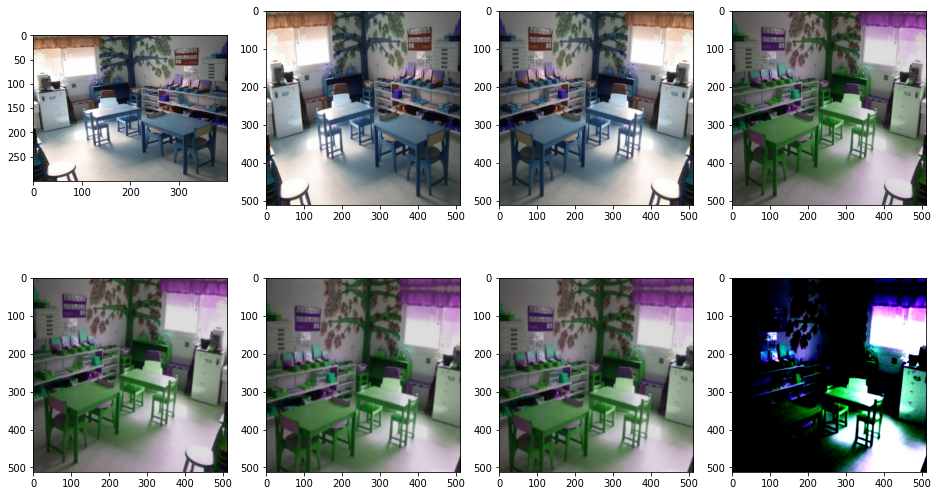

In [6]:
fig = plt.figure(figsize=(16, 9))
img = cv2.imread(train_df['file'].iloc[2], cv2.IMREAD_COLOR)
for i, aug in zip(range(1, 2*4+1), [None, *augmentations]):
    fig.add_subplot(2, 4, i)
    img = img if i==1 else aug(image=img)['image']
    plt.imshow(img)

### Training the model

A pretrained resnet34 model was chosen as a base. The final fully connected layer was changed to match the number of classes (67)

In [7]:
model = models.resnet34(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=67, bias=True)
model = model.cuda() # print(model)

The network was trained over 30 epochs, using the cross entropy loss, AdamW optimizer, and with the learning rate adjusted on plateau.

In [9]:
epochs = 30
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=7e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, verbose=True, patience=5)

def _cycle(loader, epoch, eval=False):
    ys, preds, epoch_loss, correct, total = [], [], [], 0, 0
    with tqdm(total=len(loader.dataset)-(len(loader.dataset)%batch_size), position=0, leave=True) as pbar:
        pbar.set_description(f"{'  Test' if eval else 'Train'} epoch {epoch}")
        for batch in loader:
            X, y = batch['image'].cuda(), batch['label'].cuda()
            pred = model(X)
            loss = loss_fn(pred, y)        
            if not eval:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            epoch_loss.append(loss.item())
            preds.extend(pred.argmax(1).cpu())
            ys.extend(y.cpu())
            correct, total = float(correct + sum([a==b for a,b in zip(pred.argmax(1), y)])), float(total + len(y))
            pbar.update(batch_size)
            L, A, F1 = sum(epoch_loss)/len(epoch_loss), correct/total, f1_score(ys, preds, average='macro')
            pbar.set_postfix(loss=L, accuracy=A, f1=F1)
    return L, A, F1

def train_test(loader, epoch, eval=False):
    model_state = model.eval if eval else model.train
    model_state()
    if eval:
        with torch.no_grad():
            return _cycle(loader, epoch, eval)
    else:
        return _cycle(loader, epoch, eval)

train_As, test_As, train_Ls, test_Ls, train_F1s, test_F1s = [], [], [], [], [], []
for t in range(epochs):
    train_L, train_A, train_F1 = train_test(train_dataloader, epoch=t+1, eval=False) # train
    test_L, test_A, test_F1 = train_test(test_dataloader, epoch=t+1, eval=True) # test
    for x,y in zip([train_As,test_As,train_Ls,test_Ls,train_F1s,test_F1s], [train_A,test_A,train_L,test_L,train_F1,test_F1]):
        x.append(y)
    scheduler.step(test_A)
    if test_As and test_A >= max(test_As): # enhanced accuracy, save checkpoint
        torch.save(model.state_dict(), "checkpoints/checkpoint.pth")
max_A, max_F1, balance = round(max(test_As)*100), round(max(test_F1s)*100), '_disbalanced' if disbalanced else ''
os.rename('checkpoints/checkpoint.pth', f"checkpoints/A_{max_A}_F1_{max_F1}{balance}.pth")

  Test epoch 12: 100%|██████████| 3080/3080 [00:19<00:00, 158.44it/s, accuracy=0.832, f1=0.813, loss=0.602]


Epoch 00012: reducing learning rate of group 0 to 3.5000e-05.


  Test epoch 20: 100%|██████████| 3080/3080 [00:19<00:00, 160.45it/s, accuracy=0.844, f1=0.828, loss=0.553]


Epoch 00020: reducing learning rate of group 0 to 1.7500e-05.


  Test epoch 30: 100%|██████████| 3080/3080 [00:19<00:00, 159.97it/s, accuracy=0.858, f1=0.839, loss=0.532]


Epoch 00030: reducing learning rate of group 0 to 8.7500e-06.


### Assessing the model

Various graphs below show the model performance over time<br><br>Clearly, the model still slightly overfits, so additional augmentations might improve the test accuracy. Dataset disbalance has proven to affect the metrics slightly (F1 drops by 15% on disbalanced dataset). However, balancing techniques such as focal loss weren't sufficiently effective.

In [10]:
for graph in ((train_As, test_As, 'Accuracy'), (train_Ls, test_Ls, 'Loss'), (train_F1s, test_F1s, 'F1')):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(1,len(graph[0])+1)), y=graph[0], name=f"Train {graph[2]}"))
    fig.add_trace(go.Scatter(x=list(range(1,len(graph[0])+1)), y=graph[1], name=f"Test {graph[2]}"))
    fig.update_layout(barmode='overlay', title_text=f"{graph[2]} Over Epoch", xaxis_title_text='Epoch', yaxis_title_text=graph[2])
    fig.show()

As mentioned before, F1 is higher for bigger classes, although the correlation is not very strong. <br><br>For the network, the most confusing classes to tell apart were <b>deli / bakery</b> and <b>restaurant / bar</b> (which are, in fact, quite similar)

In [13]:
proba, ys, preds = [], [], []
model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        X, y = batch['image'].cuda(), batch['label'].cuda()
        ys.extend([int(u) for u in y.cpu()])
        pred = model(X).cpu()
        preds.extend([int(u) for u in pred.argmax(1).cpu()])
        proba.extend([float(max(u)) for u in softmax(pred).cpu()])

df_metrics = pd.DataFrame(index=df['tmp'].unique(), data={'F1':f1_score(ys, preds, average=None)})
df_metrics['ClassSize'] = df.groupby(['tmp']).count()['label']
fig = px.scatter(df_metrics, x='ClassSize', y='F1', title="F1 by Class Size")
fig.show()

conf = pd.DataFrame(confusion_matrix(y_true=ys, y_pred=preds)).rename(columns=label_dict, index=label_dict)
for x in range(len(conf)):
    conf.iloc[x,x] = np.nan
    conf.iloc[x] = conf.iloc[x].apply(lambda x: np.nan if x<5 else x)
for col in conf:
    conf = conf.dropna(how='all').dropna(how='all', axis='columns') # conf = conf.dropna(how='all', axis='columns')
fig = px.imshow(conf, labels=dict(x="Predicted", y="Actual"))
fig.show()

The next cell focuses more on the networks's mistakes. Below are the pictures which the model was the least sure about (classified incorrectly with the smallest probabilities)

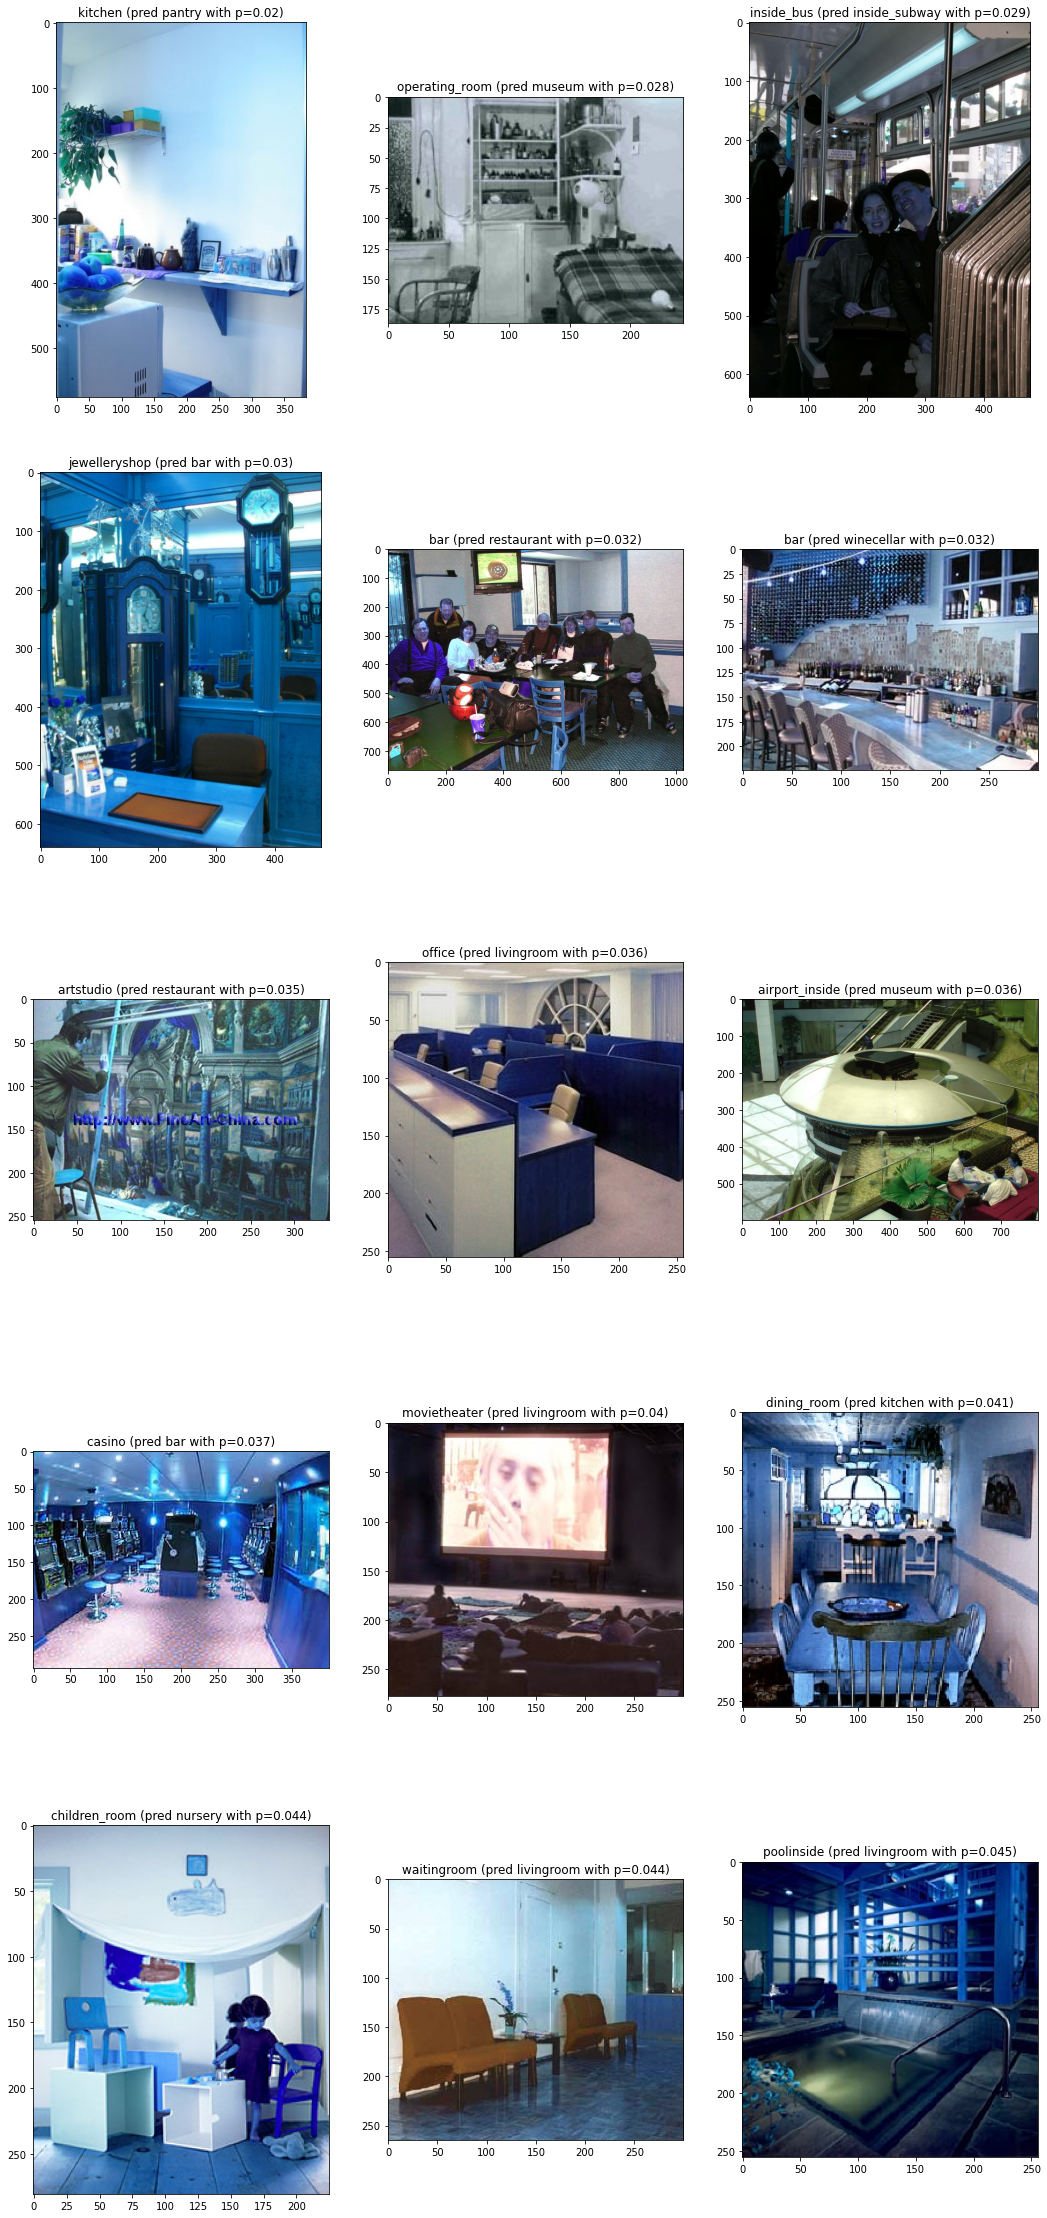

In [12]:
mistakes = {}
for img_id, real, predicted, probability in zip(range(len(preds)), ys, preds, proba):
    if real != predicted:
        mistakes[img_id] = (probability, predicted)

fig, rows, columns = plt.figure(figsize=(18, 40)), 5, 3
for i, img_id in zip(range(1, rows*columns+1), dict(sorted(mistakes.items(), key=lambda x: x[1][0]))):
    ax = fig.add_subplot(rows, columns, i)
    real_class, predicted_class = label_dict[test_df['label'].iloc[img_id]], label_dict[mistakes[img_id][1]]
    ax.set_title(label=f"{real_class} (pred {predicted_class} with p={round(mistakes[img_id][0], 3)})")
    plt.imshow(cv2.imread(test_df['file'].iloc[img_id], cv2.IMREAD_COLOR))